# 0. Introduction

In this notebook, I will perform topic modeling on a collection of product reviews scraped from Amazon.com.  Specifically, I seek to extract actionable marketing and product insights from Nike footwear reviews.

[Dataset courtesy of Julian McCauley](http://jmcauley.ucsd.edu/data/amazon/links.html)

---
# 1. Setup

**Note:** For a previous assignment in this course, I downloaded/extracted the datasets and generated a list of ASINs (Amazon Store Id Numbers) associated with Nike products.  Those steps are not repeated in this notebook.



In [ ]:
## raw metadata file available at the following url
# !wget http://128.138.93.164/meta_Clothing_Shoes_and_Jewelry.json.gz

## raw product review file available at the following url
# !wget http://128.138.93.164/reviews_Clothing_Shoes_and_Jewelry.json.gz

In [ ]:
%%capture
!pip install bertopic

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from bertopic import BERTopic

%matplotlib inline

In [ ]:
DATA_DIR = "/content/drive/MyDrive/*DTSA 5799: Unsupervised Text Classification/Data"
PROJECT_DIR = "/content/drive/MyDrive/*DTSA 5799: Unsupervised Text Classification/Project" 

## Load Nike ASIN list

Note: `allasins.txt` was generated during a previous assignment

In [ ]:
# load list of all nike asins
nike_asins = []
with open(f"{DATA_DIR}/allasins.txt", "r") as f:
  for data in f:
    for asin in data.split(","):
      nike_asins.append(asin)

print(f"found {len(nike_asins)} unique Nike asins")

found 8327 unique Nike asins


## Save all Nike reviews as jsonl file

In [ ]:
# make dictionary containing all nike reviews
nike_reviews = {}
with open(f"{DATA_DIR}/reviews_Clothing_Shoes_and_Jewelry.json", "r") as f:
  for i, review in enumerate(f):
    review = json.loads(review)
    if review.get("asin") in nike_asins:
      _id = f"{review['asin']}.{review['reviewerID']}"
      nike_reviews[_id] = review

    # monitor progress
    if i % 100000 == 0: 
      print(f"\r searched through {round(i/1000000,1)}M records", end='')

print(f"found {len(nike_reviews)} Nike product reviews")

In [ ]:
# save all nike reviews as jsonl file
with open(f"{PROJECT_DIR}/all_nike_reviews.jsonl", "w") as nike_reviews_file:
  for k, v in nike_reviews.items():
    review = json.dumps(v)
    nike_reviews_file.write(f"{review}\n")

## Save all Nike product metadata as jsonl file

In [ ]:
# make dictionary of all nike product metadata
nike_meta = {}
with open(f"{DATA_DIR}/meta_Clothing_Shoes_and_Jewelry.json", "r") as f:
  for i, line in enumerate(f):
    product = eval(line) #use eval() because this file is a python dictionary, NOT valid json
    if product['asin'] in nike_asins:
      nike_meta[product['asin']] = product
    
    # monitor progress
    if i % 100000 == 0: 
      print(f"\r searched through {round(i/1000000,1)}M products", end='')

print(f"found metadata for {len(nike_meta)} Nike products")

 searched through 1.5M products

In [ ]:
# save all nike reviews in jsonl file
with open(f"{PROJECT_DIR}/all_nike_meta.jsonl", "w") as nike_meta_file:
  for k, v in nike_meta.items():
    meta = json.dumps(v)
    nike_meta_file.write(f"{meta}\n")

## Inspect shoe sale rankings

In [ ]:
# get sales rankings of shoes that appear in this dataset
all_shoe_ranks = set()
nike_shoe_ranks = set()
nike_shoe_count = 0
nike_shoe_asins = set()

with open(f"{DATA_DIR}/meta_Clothing_Shoes_and_Jewelry.json", "r") as f:
  for i, line in enumerate(f):
    product = eval(line) #use eval() because this file is a python dictionary, NOT valid json

    if "salesRank" in product:
      for cat, rank in product["salesRank"].items():
        if cat == "Shoes":
          all_shoe_ranks.add(rank)
          if product.get("asin") in nike_asins:
            nike_shoe_ranks.add(rank)
            nike_shoe_count += 1
            nike_shoe_asins.add(product["asin"])

    # monitor progress
    if i % 100000 == 0: 
      print(f"\r searched through {round(i/1000000,1)}M products", end='')

print(f"\n found {len(nike_shoe_ranks)} distinct nike shoe sales ranks ({len(all_shoe_ranks)} total shoe ranks)")
print(f"\n found {nike_shoe_count} metadata entries for nike shoes")
print(f"\n found {len(nike_shoe_asins)} unique asins associated with nike shoes")

 searched through 1.5M products
 found 5440 distinct nike shoe sales ranks (175056 total shoe ranks)

 found 6599 metadata entries for nike shoes

 found 6599 unique asins associated with nike shoes


**Note:** The conflicting counts for nike_shoe_ranks elements and the nike_shoe_count counter indicates that multiple Nike products share the same sales rankings.  This is further supported by the fact that unique asins matches metadata entries, which are both greater than the number of unique sales ranks.

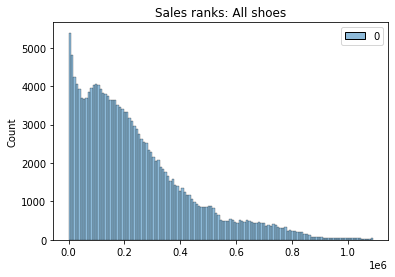

In [ ]:
# sales ranks of ALL shoes appearing in this dataset.  
sns.histplot(all_shoe_ranks).set(title="Sales ranks: All shoes");plt.show()

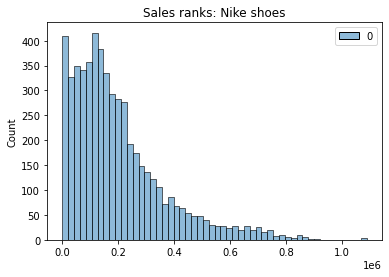

In [ ]:
# sales ranks of Nike shoes appearing in this dataset.  
sns.histplot(nike_shoe_ranks).set(title="Sales ranks: Nike shoes"); plt.show()

**Notes** 
* The sales rank distribution of Nike shoes and All shoes are a close match
* The distribution is nowhere near uniform.  Therefore, many of the shoes that are incorporated into Amazon's rankings do not appear in this dataset. Most of the "missing" shoes have poor sales ranks.


## Add percentile sale ranks to Nike shoes metadata



As demonstrated in the previous plots, this dataset is missing many of the shoes that Amazon includes in their sales rankings.  Most of the missing shoes have weak sales ranks.

I'll add percentile sales ranks (with respect to other shoes in this dataset) to the Nike shoes metadata.  Percentile sales ranks will be useful to determine which Nike shoes have relatively strong or weak sales compared to other product lines.

In [ ]:
all_shoe_rank_array = np.sort( np.array(list(all_shoe_ranks)) )

# convert shoe sales rank from raw rank to percentile of all shoes(larger value = more popular)
def percentile_all_shoe_ranks(sales_rank):
  pct_rank = 1 - np.where(all_shoe_rank_array == sales_rank)[0][0] / all_shoe_rank_array.shape[0]
  return pct_rank

In [ ]:
# make dictionary of all nike shoes metadata
nike_shoe_meta = {}
with open(f"{DATA_DIR}/meta_Clothing_Shoes_and_Jewelry.json", "r") as f:
  for i, line in enumerate(f):
    product = eval(line) #use eval() because this file is a python dictionary, NOT valid json
    if product['asin'] in nike_asins:

      # add percentile salesRank for Nike shoes
      if product.get("salesRank"):
        for cat, rank in product["salesRank"].items():
          if cat == "Shoes":
            product["pct_sales_rank"] = percentile_all_shoe_ranks(rank)
            nike_shoe_meta[product['asin']] = product
    
    # monitor progress
    if i % 100000 == 0: 
      print(f"\r searched through {round(i/1000000,1)}M products", end='')

print(f"\n found metadata and percentile rank for {len(nike_shoe_meta)} Nike shoes")

 searched through 1.5M products
 found metadata and percentile rank for 6599 Nike shoes


In [ ]:
# verify percentiles correctly added to metadata
sample_asin = list(nike_shoe_meta.keys())[1]
print(nike_shoe_meta[sample_asin])

{'asin': 'B0006NGUE6', 'title': "Nike Men's Air Rival Golf Shoes (Medium) (11 D(M), White/Khaki/Medium Brown)", 'imUrl': 'http://ecx.images-amazon.com/images/I/41vL%2BnrczWL._SY395_.jpg', 'related': {'also_bought': ['B000AYI8R8', 'B006LMIAJO', 'B004VK17C0', 'B003BF8NSM', 'B0027IAEHC', 'B00A24DB4G', 'B003UO5QSY', 'B003HAG5D6', 'B001P2XCA2', 'B001RVC7JS', 'B006MIOZX2', 'B003IIH0IG', 'B00894PZ04', 'B006LMH2Q6', 'B000GG1ICM', 'B002V9PB2A', 'B0043D2MHO', 'B005HFCSVC', 'B004RL0J9U', 'B00BMPBFWE', 'B007FTY0HS', 'B00455GNMA', 'B0098GABWY', 'B004E4IVMM', 'B0055NW0WS', 'B008Q7Q7WE', 'B00HMDXHW6', 'B00LPADNHG', 'B008VOMNN4', 'B001ZY65Q8', 'B004V95TYI', 'B008JO4UAA', 'B004E4K3OG', 'B007FLTEUO', 'B004V95XNK', 'B001B6CH6C', 'B004RL0J9K', 'B002S53MCI', 'B009EPO792', 'B004H43QU6', 'B004V95XSU', 'B005GPDKQA', 'B003Q4MWQM', 'B009LPHE1S', 'B00BHRN44Y', 'B0055NW9BK', 'B00B4FJQTQ', 'B002IJ7LV2', 'B00A8XP75W', 'B0013EGVQO', 'B0098GAFAC', 'B000LSOPUC', 'B004LFWFMQ', 'B000A0A3ZM', 'B004N55H24', 'B000KGDYQG', 

In [ ]:
# save Nike shoes metadata as jsonl file
with open(f"{PROJECT_DIR}/nike_shoes_meta.jsonl", "w") as nike_shoes_meta_file:
  for k, v in nike_shoe_meta.items():
    meta = json.dumps(v)
    nike_shoes_meta_file.write(f"{meta}\n")

## Get list of Nike shoe reviews for BERTopic modeling


In [ ]:
nike_shoe_asin_list = []
asin_to_rank = {}
asin_to_title = {}

# Get list of Nike shoe ASINs; map ASINs to sales ranks and product titles
with open(f"{PROJECT_DIR}/nike_shoes_meta.jsonl", "r") as f:
  for line in f:
    product = json.loads(line)
    nike_shoe_asin_list.append(product["asin"])
    if product.get("pct_sales_rank") != None:
      asin_to_rank[product["asin"]] = product["pct_sales_rank"]
      asin_to_title[product["asin"]] = product["title"]

print(f"{len(nike_shoe_asin_list)} Nike shoe ASINs found")
print(f"{len(asin_to_rank)} ASINs mapped to percentile sales ranks ")


nike_shoe_review_list = []
asins_from_review_list = []
ranks_from_review_list = []
titles_from_review_list = []

# Get lists of Nike shoe reviews and corresponding ASINs, percentile sales ranks, and product titles
with open(f"{PROJECT_DIR}/all_nike_reviews.jsonl", "r") as f:
  for line in f:
    review = json.loads(line)
    if review["asin"] in nike_shoe_asin_list:
      nike_shoe_review_list.append(review["reviewText"])
    
      asins_from_review_list.append(review["asin"])
      ranks_from_review_list.append(asin_to_rank[review["asin"]])
      titles_from_review_list.append(asin_to_title[review["asin"]])

print(f"{len(nike_shoe_review_list)} Nike shoe reviews found")

6599 Nike shoe ASINs found
6599 ASINs mapped to percentile sales ranks 
16841 Nike shoe reviews found


---
# 2. Topic modeling

I will use [BERTopic](https://maartengr.github.io/BERTopic/index.html) for this topic modeling task.  BERTopic involves the following steps:
  * Use the [Sentence-BERT](https://www.sbert.net/) framework to generate document embeddings
  * Reduces the dimensionality of the embeddings with [UMAP](https://umap-learn.readthedocs.io/en/latest/)
  * Cluster the embeddings with the [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html) algorithm
  * Generate topic representations using a class-based TF-IDF procedure

**Note:** BERTopic assumes that each document consists of a single topic.  This assumption is reasonable enough for our dataset since most reviews are 1 sentence long, and none are longer than a short paragraph. Also, this limitation is only an issue when extracting the topics.  After topics have been identified, we can re-evaluate our documents if we suspect individual documents contain multiple of the topics that we identified.





## Data preprocessing

The BERTopic documentation strongly recommends using sentence transformer models to generate document embeddings. 

Sentence transformer performance is harmed by many common text pre-processing techniques such as stemming, lemmatization, and stop word removal.  The only recommended pre-processing is to address hyperlinks, hashtags, unicode characters, or misspelled words &mdash; none of which are a concern in this dataset. 

Therefore, no pre-processing is needed.


## Fitting BERTopic models

The 2 most important BERTopic hyperparameters for this task are the choice of sentence transformer model (document embeddings) and the maximum number of clusters (topics) to generate. 

I tried `all-MiniLM-L6-v2` and `all-mpnet-base-v2`, but I was happiest with the results from the `all-distilroberta-v1` sentence transformer.  Specifically, I liked that the distilroberta model did a better job of considering complaints and praise to be distinct topics &mdash; which was extremely useful since I wanted to avoid explicitly performing sentiment analysis.

Setting `nr_topics=40` worked well enough.  HDBSCAN's automatic clustering yielded an unmanageable number of redundant topics (100+). I was equally unhappy when automatically reducing clusters since uncommon, important topics were often being removed.  40 topics worked well as a starting point for manually merging and removing topics.


In [ ]:
# # Fit new BERTopic model

# topic_model = BERTopic(
#     embedding_model="all-distilroberta-v1",
#     language="english", 
#     verbose=True, 
#     calculate_probabilities=True, 
#     nr_topics=40)

# topics, probs = topic_model.fit_transform(nike_shoe_review_list)

In [ ]:
# # Save model
# topic_model.save(f"{PROJECT_DIR}/distilroberta_v1_model_2")

In [ ]:
#Load saved BERTopic model
topic_model = BERTopic.load(f"{PROJECT_DIR}/distilroberta_v1_model_2", embedding_model="all-distilroberta-v1")	
topics = topic_model.topics_
probs = topic_model.probabilities_

Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/653 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/15.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/333 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]


## Cleaning topic representations 

Right now, the topic representations are dominated by useless words that would be found on most common stop word lists. These words were important when generating document embeddings, but they aren't helpful for the c-TF-IDF procedure that generates human-readable topic representations.

**Note:** Removing stop words from the topic representation *only* improves readability. The embedding clusters (topics) are *not* being altered.

In [ ]:
# remove stop words from the topic representations
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer

my_stop_words = ENGLISH_STOP_WORDS.union(["flop", "11", "10", "max", "34", "shoe", "shoes"]) # add specific stop words to the default list
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words=my_stop_words)

topic_model.update_topics(nike_shoe_review_list, vectorizer_model=vectorizer_model)

## Examining topics 

In [ ]:
freq = topic_model.get_topic_info()
freq.head()

,Topic,Count,Name
0,-1,9617,-1_great_comfortable_size_fit
1,0,944,0_loves_son_gift_bought
2,1,336,1_running_run_miles_light
3,2,330,2_son_loves_son loves_old
4,3,311,3_comfortable_good_gym_light


In [ ]:
topic_model.visualize_topics()

### Utility functions for examining topics


In [ ]:
# function for pulling ALL docs from a specific topic
def pull_docs(topic_to_pull, N_docs_to_print=None, return_docs_pulled=False, return_indices=False, tm=topic_model, review_list=nike_shoe_review_list):
  topics = tm.topics_
  docs_pulled = []
  indices_of_docs = []
  for i in range(len(review_list)):
    if topics[i] == topic_to_pull:
      docs_pulled.append(review_list[i])
      indices_of_docs.append(i)

      #stop early if all we're doing is printing
      if (return_docs_pulled == False) and (return_indices == False) and (len(docs_pulled) >= N_docs_to_print):
        break 

  if N_docs_to_print != None:
    for i, doc in enumerate(docs_pulled):
      if i <= N_docs_to_print:
        print(f"\n * [{titles_from_review_list[ indices_of_docs[i] ]}] {doc}")
  
  if (return_docs_pulled == True) and (return_indices==False):
    return docs_pulled
  elif (return_docs_pulled == False) and (return_indices==True):
    return indices_of_docs
  elif (return_docs_pulled == True) and (return_indices==True):
    return (docs_pulled, indices_of_docs)


# returns a dataframe with product titles and counts for a given topic, sorted by count (descending)
def get_product_counts(topic_to_pull, print_top_N=False, titles_list=titles_from_review_list):
  titles_ = [titles_list[i] for i in pull_docs(topic_to_pull, return_indices=True)]
  title_values, title_counts = np.unique(np.array(titles_), return_counts=True)

  df = pd.DataFrame({"title": title_values, "counts": title_counts})
  df.sort_values(by=["counts"], ascending=False, inplace=True)

  if print_top_N != False:
    print(df.head(print_top_N))
  else: return df

## Merging and removing topics 

The Intertopic Distance Map shows ~8 distinct clusters of topics.  This is a great starting point, but we can improve it by merging similar topics and removing topics that aren't useful.


**Topics to merge**
* 0, 2, 22, 28:  Positive reviews regarding shoes purchased on behalf of a family member

* 5, 7: positive reviews mentioning fast delivery

* 4, 14, 26: Shoes smaller than expected

**Topics to remove**

* 13, 15, 17, 23, 24: Discussion about a specific product line (Airmax, Jordans, Shox, Free Runs, and Pegasus)
  * The presence of these topics is worth noting, but not helpful for this specific project since reviews can be sorted by product line if desired.  Re-classifying these reviews will make it easier to see what customers specifically like or dislike about the product lines.

* 8, 33, 36: Sandals, slides, flip-flops
  * Removing these topics and re-classifying the associated reviews will make it easier to identify specific strengths and weaknesses of these products.



In [ ]:
# manually merging topics
topics_to_merge = [
  [0,2,22,28],
  [5,7],
  [4,14,26],
  [-1,8,13,15,17,23,24,33,36] # remove topics by merging them with "outliers" topic
]
topic_model.merge_topics(nike_shoe_review_list, topics_to_merge)

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_barchart(topics=list(range(0,12)), n_words=7)

The updated Intertopic Distance Map shows 3 loose groupings of topics, but each topic within the groupings are distinct enough to be useful.  The three topic groupings might be described as:


* Structural/engineering
  * fit/sizing
  * construction quality
  * design flaws
* Shopping experience.
  * color options
  * shipping/ordering experience
  * product returns/refunds
  * price
  * counterfeits
* Specific use cases
  * running
  * "work shoe" 
  * sports

---
# 3. Document classification

We identified 26 useful topics among our documents, but most of the documents remain unclassified (BERTopic uses the `-1` label to indicate "outlier" docs).  

Many of these "outlier" documents weren't initially assigned to any topic (cluster) by the HDBSCAN algorithm.  Others were labeled with a topic that I manually removed.  In both cases, there is a good chance that these documents contain one or more of the 26 remianing topics. However, the documents are not *guaranteed* to contain any of the remaining topics, so I will allow documents to keep their "outlier" label if all of the topics are a poor match.



In [ ]:
# re-assign outlier/unassigned documents to new topics if a reasonably close match can be found
probability_threshold = 0.05
new_topics = []
for i, t in enumerate(topic_model.topics_):
  if t == -1:
    t_ = np.argmax(topic_model.probabilities_[i]) if ( max(topic_model.probabilities_[i]) >= probability_threshold) else -1
    new_topics.append(t_)
  else:
    new_topics.append(t)

topic_model.update_topics(nike_shoe_review_list, topics=new_topics, vectorizer_model=vectorizer_model)

In [ ]:
freq = topic_model.get_topic_info()
freq

,Topic,Count,Name
0,-1,5310,-1_nike_comfortable_pair_great
1,0,2893,0_son_loves_fit_great
2,1,2447,1_size_small_nike_fit
3,2,1526,2_great_product_good_fit
4,3,603,3_running_run_feet_miles
5,4,530,4_comfortable_good_great_light
6,5,263,5_basketball_court_play_ankle
7,6,219,6_muy_el_la_en
8,7,313,7_nike_love_great_comfortable
9,8,189,8_money_like_just_make


---
# 4. Investigating Topics

We have finalized our topics and classified our documents.  All that remains is to investigate the topics in search of actionable insights.  

Product insights are most useful when they can be directly related to sales. Assigning the products to classes based on their sales ranking will let us quickly identify any strong relationship between topic prevalence and sales ranking.  We can use BERTopic's `topics_per_class()` method to find the relative frequency of topics among products with strong and weak sales.  The method also returns fine-tuned topic representations that are specific to a given class's documents.




In [ ]:
# partition reviews into 4 rougly equal bins based on sales rankings.
class_from_review_list = []
for rank in ranks_from_review_list:
  if rank >= 0.95: class_from_review_list.append(4)
  elif rank >= 0.8: class_from_review_list.append(3)
  elif rank >= 0.6: class_from_review_list.append(2)
  elif rank>= 0: class_from_review_list.append(1)
  else: class_from_review_list.append(-1)


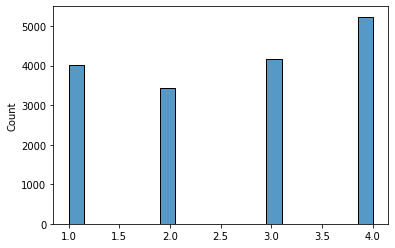

In [ ]:
# check that the number of reviews is roughly equal for each sales rank bin
sns.histplot(class_from_review_list)

In [ ]:
topics_per_class = topic_model.topics_per_class(nike_shoe_review_list, class_from_review_list)

#normalize frequency counts by number of reviews in each class
topics_per_class["Proportion_of_class"] = topics_per_class["Frequency"]
class_counts = np.unique(np.array(class_from_review_list), return_counts=True)[1]
for i in topics_per_class.Class.unique():
  topics_per_class.loc[topics_per_class["Class"]==i, "Proportion_of_class"] = topics_per_class["Proportion_of_class"] / class_counts[i-1]


4it [00:01,  2.25it/s]


## Sample code

The following cell is an example of the code used when investigating topics. 



In [ ]:
# This cell makes it easy to view key information about a given topic
topic_number=21

get_product_counts(topic_number,10)
pull_docs(topic_number,10,tm=topic_model)
topics_per_class[topics_per_class["Topic"]==topic_number]

                                               title  counts
5     Nike Air Monarch IV Men's Cross Training Shoes      81
0  Air Jordan 8.0 Black Aqua Mens Basketball 4678...       1
1  NIKE Air Jordan 11 Retro Low Black New Shoes W...       1
2   Nike Air Max '95 336620-163 Womens Running Shoes       1
3  Nike Air Max Speed Turf Raider Mens Cross Trai...       1
4              Nike Air Max+ 2011 Mens Running Shoes       1
6                     Nike Air Monarch Iii (4E) Mens       1
7                          Nike Air Visi Pro Iii Nbk       1
8       Nike Free 5.0+ Mens Running Shoes 579959-740       1
9  Nike Lady Air Alvord 8 Water Shield Trail Runn...       1

 * [Nike Men's Air Max LTD Running Shoe] The shoes fit great and feel good. After a few months both shoes got a tear in the sole. Now the shoes always make a whistling noise when I walk.

 * [Air Jordan 8.0 Black Aqua Mens Basketball 467807-009 (13)] I have had these for over a year and though they are extremely comfortable th

,Topic,Words,Frequency,Class,Proportion_of_class
22,21,"squeak, squeaking, noise, squeaks, noticed",5,1,0.001249
49,21,"embarrassed wear, embarrassed, squeak, things,...",2,2,0.000581
76,21,"noise, squeak, annoying, step, squeek hr",5,3,0.001201
103,21,"squeak, squeaking, powder, loud, nike",83,4,0.015858


## Topic Descriptions

Below is a list of descriptions for each topic, presented in descending order of frequency.  Accompanying each description is a symbol indicating whether reviews within the topic were generally positive (+), negative (&ndash;), or mixed (~).



* Topic 0: (+) Purchased for a family member (often as a gift) who is happy with the product.  

* Topic 1: (+) Shoe is smaller than expected (i.e., "sizes run small"). 
  * Notes: Surprisingly, this topic is associated with strong sales rankings and the majority of these reviews are positive overall.

* Topic 2: (+) Shoes were delivered quickly; product was as described. 

* Topic 3: (+) Great running shoes.  Comfortable and lightweight.  
  * Notes: Topic is even balanced among sales rankings

* Topic 4: (+) Comfortable, attractive, general-purpose footwear.  
  * Notes: Topic associated with stronger sales rankings.

* Topic 5: (+) First-hand experience using the shoe while playing basketball.  
  * Notes: Many of these reviews comment on ankle support/stability and value (price vs. performance).

* Topic 6: (~) Spanish language reviews.  
  * Notes: Topic is most common among shoes with weak overall sales rankings. 

* Topic 7: (+) Nike brand loyalty. 
  * Notes: This topic is rare among the very best selling shoes, but very common for the second-best tier (80-95 percentile sales ranking)

* Topic 8: (&ndash;) Outrageously high priced shoes. 
  * Notes: This topic is strongly associated with Nike Air Foamposite, Nike Air Yeezy, and "retro" shoes.

* Topic 9: (+) Comfortable work-shoes appropriate for jobs that require standing for 10-12 hour shifts.  
  * Notes: Evenly distributed among sales ranking tiers.

* Topic 10: (+) Focused on the appearance/style/fashion of the shoe.  
  * Notes: Most common among top ranked shoes.

* Topic 11: (&ndash;) Narrow, uncomfortable shoes. 
  * Notes: Surprisingly, this topic is associated with higher sales rankings.

* Topic 12: (+) Reviewing performance of cleats for their intended sport.     
  * Notes: Topic is associated with poor sales rankings.  

* Topic 13: (&ndash;) Shoes falling apart after a few weeks/months.  
  * Notes: Slightly more common for products with lower sales rankings.  This topic is associated with a wide range of products.

* Topic 14: (~) Reviewing performance in adverse (cold, rainy, muddy, etc.) weather conditions.  

* Topic 15: (&ndash;) Shoes returned/refunded; generally critical of the return policy.  
  * Notes: Customers extremely unhappy about re-stocking fees. Topic not associated with any particular product lines.

* Topic 16: (&ndash;) Blisters and foot pain; uncomfortable shoes.  
  * Notes: Topic is (weakly) associated with high sales ranking.

* Topic 17: (+) Comfortable work-out shoes appropriate for a wide variety of physical activities.  
  * Notes: Topic is commonly associated with the Nike Free product line.

* Topic 18: (~) "Running shoes" that aren't great for running
  * Notes: Misleading marketing seems to be the biggest complaint.  Shoes are well regarded as a "general purpose" shoe but customers who bought them for long-distance running are unhappy.

* Topic 19: (&ndash;) Counterfeit shoes.  
  * Notes: Some shoes may be authentic but suffer from egregious quality control issues that make them seem fake.  This topic is strongly associated with Air Jordans, retro shoes, and other high-priced  product lines. 

* Topic 20: (~) Color of shoes was not as advertised.  
  * Notes: Not associated with any particular product line.  Surprisingly, many reviewers liked the color they received, even though it wasn't as expected.

* Topic 21: (~) Shoes make obnoxious noises (squeeking, popping, whistling, etc.)  
  * Notes: Overwhelmingly associated with the Nike Air Monarch IV. Reviewers hate the noises, but are usually positive overall since everything else about the Monarch product line is well-received.  

* Topic 22: (+) Reviews by parents whose children use these shoes on a basketball team.

* Topic 23: (+) Golf-oriented reviews.
  * Notes: Generally considered to be a good shoe for the price.

* Topic 24: (+) Tennis-oriented reviews.  

* Topic 25: (+) Wide selection of bright, vibrant colors. 








---
# 5. Conclusion &mdash; Marketing insights



## Style over substance
* Customers claim that comfort is an important factor when buying shoes, but there is no evidence of a link between comfort/discomfort and sales rankings.  Discomfort was not associated with weak sales. Comfort was not associated with strong sales except in reviews that were also positive about the appearance of the shoe.  However, fashionable/attractive/colorful shoes seemed to sell better regardless of whether the shoes were perceived as comfortable.
* Appearance may be uniquely important for online sales since customers see pictures of the shoes but can't try them on.
* High performance shoes designed for a specific purpose always showed weak sales, even when the product line had glowing reviews.  This isn't surprising &mdash; most of the population doesn't actively compete in organized sports or run marathons &mdash; but it's worth pointing out. 

## Nike shoes are popular gifts
* The most common topic concerns buying Nike shoes as a gift for family members &mdash; especially sons.  Nike should consider ad campaigns that target parents before major holidays and special occasions (e.g., birthdays).  Further research may reveal specific patterns regarding familial relationship and gift-giving events (e.g., shoes for dad on Father's Day, shoes for son as graduation gift, shoes for boyfriend on Valentine's Day, etc.).

## Evidence of product-line loyalty
* Topic 7 suggests that Nike brand loyalty is associated with reasonably strong sales, but isn't linked to top-selling products.  
* However, several top-selling products showed evidence of consumer loyalty to the product line.  Shox, Free Run, Monarch, Jordan, Pegasus, and Air Max product lines each have strong sales and had many reviews comparing a specific model to prior generations of the product line that they had purchased.  
* Taken at face value, this trend suggests that Nike may be more successful when marketing individual product lines than pushing the brand as a whole.
* Minor style updates were often well received, but major design changes (such as materials or structural changes) were often referenced negatively.  This suggests that Nike should be careful not to deviate from the core identity of these popular product lines.


## Shoe size confusion
* ~15% of all reviews were complaints about misleading shoe sizes.  Sizing complaints were common across a broad range of Nike products.  Reviews complaining about shoe width were much more negative than complaints about length.  
* Notably, neither type of sizing complaint was associated with poor sales.  This leads to the conclusion that sizing complaints can be ignored. However, sizing issues directly increase the chances that customers will have to go through the return process...

## Customers dislike the return/refund process
* Topic 15 reveals that customers dislike the return/refund process.  Re-stocking fees made customers particularly upset.  Quite a few reviewers were angry enough to claim that they will never again buy Nike shoes.  
* It's not clear to me that Nike plays any role in Amazon's return/refund process, but some customers don't seem to make that distinction. Nike may not be able to do anything about this complaint, but it's worth looking into.  

## Counterfeit concerns
* Topic 19 raises concerns that customers are receiving counterfeit shoes.  Further investigation is needed to determine how these counterfeits are being distributed.  Are counterfeits purchased from official Nike listings, or are the counterfeits being sold by an independent retailer impersonating Nike?
* The counterfeits seem to affect expensive items with low sales volumes, so Nike might consider removing these product listings from Amazon if this problem cannot be resolved.


## Spanish language reviews
* Spanish language reviews were associated with lower sales rankings. This may indicate that Spanish speaking customers have different shoe preferences than English speaking customers.  If this is the case, Nike might consider tailoring specific products to the tastes of these customers. 
* Note: Reviews weren't translated, so more research is needed before we can be confident in any conclusion.


